# Energy resolution after fidutials

## DEMO Run7


### April 2021, JAH

In [35]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [36]:
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt

In [37]:
import hipy.utils        as ut
import hipy.pltext       as pltext

import next.core.io        as nio
import next.core.selection as nsel

import next.eres.eres      as eres

In [38]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Thu Apr 15 13:19:56 2021


### load data

In [39]:
filename  = f'/home/hernando/data/demo/run7/dfesme_fidutial_combined.h5'
dft       = pd.read_hdf(filename, 'esme')
print('total number of events ', len(dft))

total number of events  913222


### Inspect DF

['event', 'trackID', 'energy', 'length', 'numb_of_voxels', 'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'r_min', 'x_max', 'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'r_ave', 'extreme1_x', 'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y', 'extreme2_z', 'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y', 'blob2_z', 'eblob1', 'eblob2', 'ovlp_blob_energy', 'dz_track', 'enecor', 'time', 'nS2', 'S1e', 'S2e', 'S2q', 'Nsipm', 'evt_energy', 'evt_ntrks', 'evt_nhits', 'evt_out_of_map', 'run']


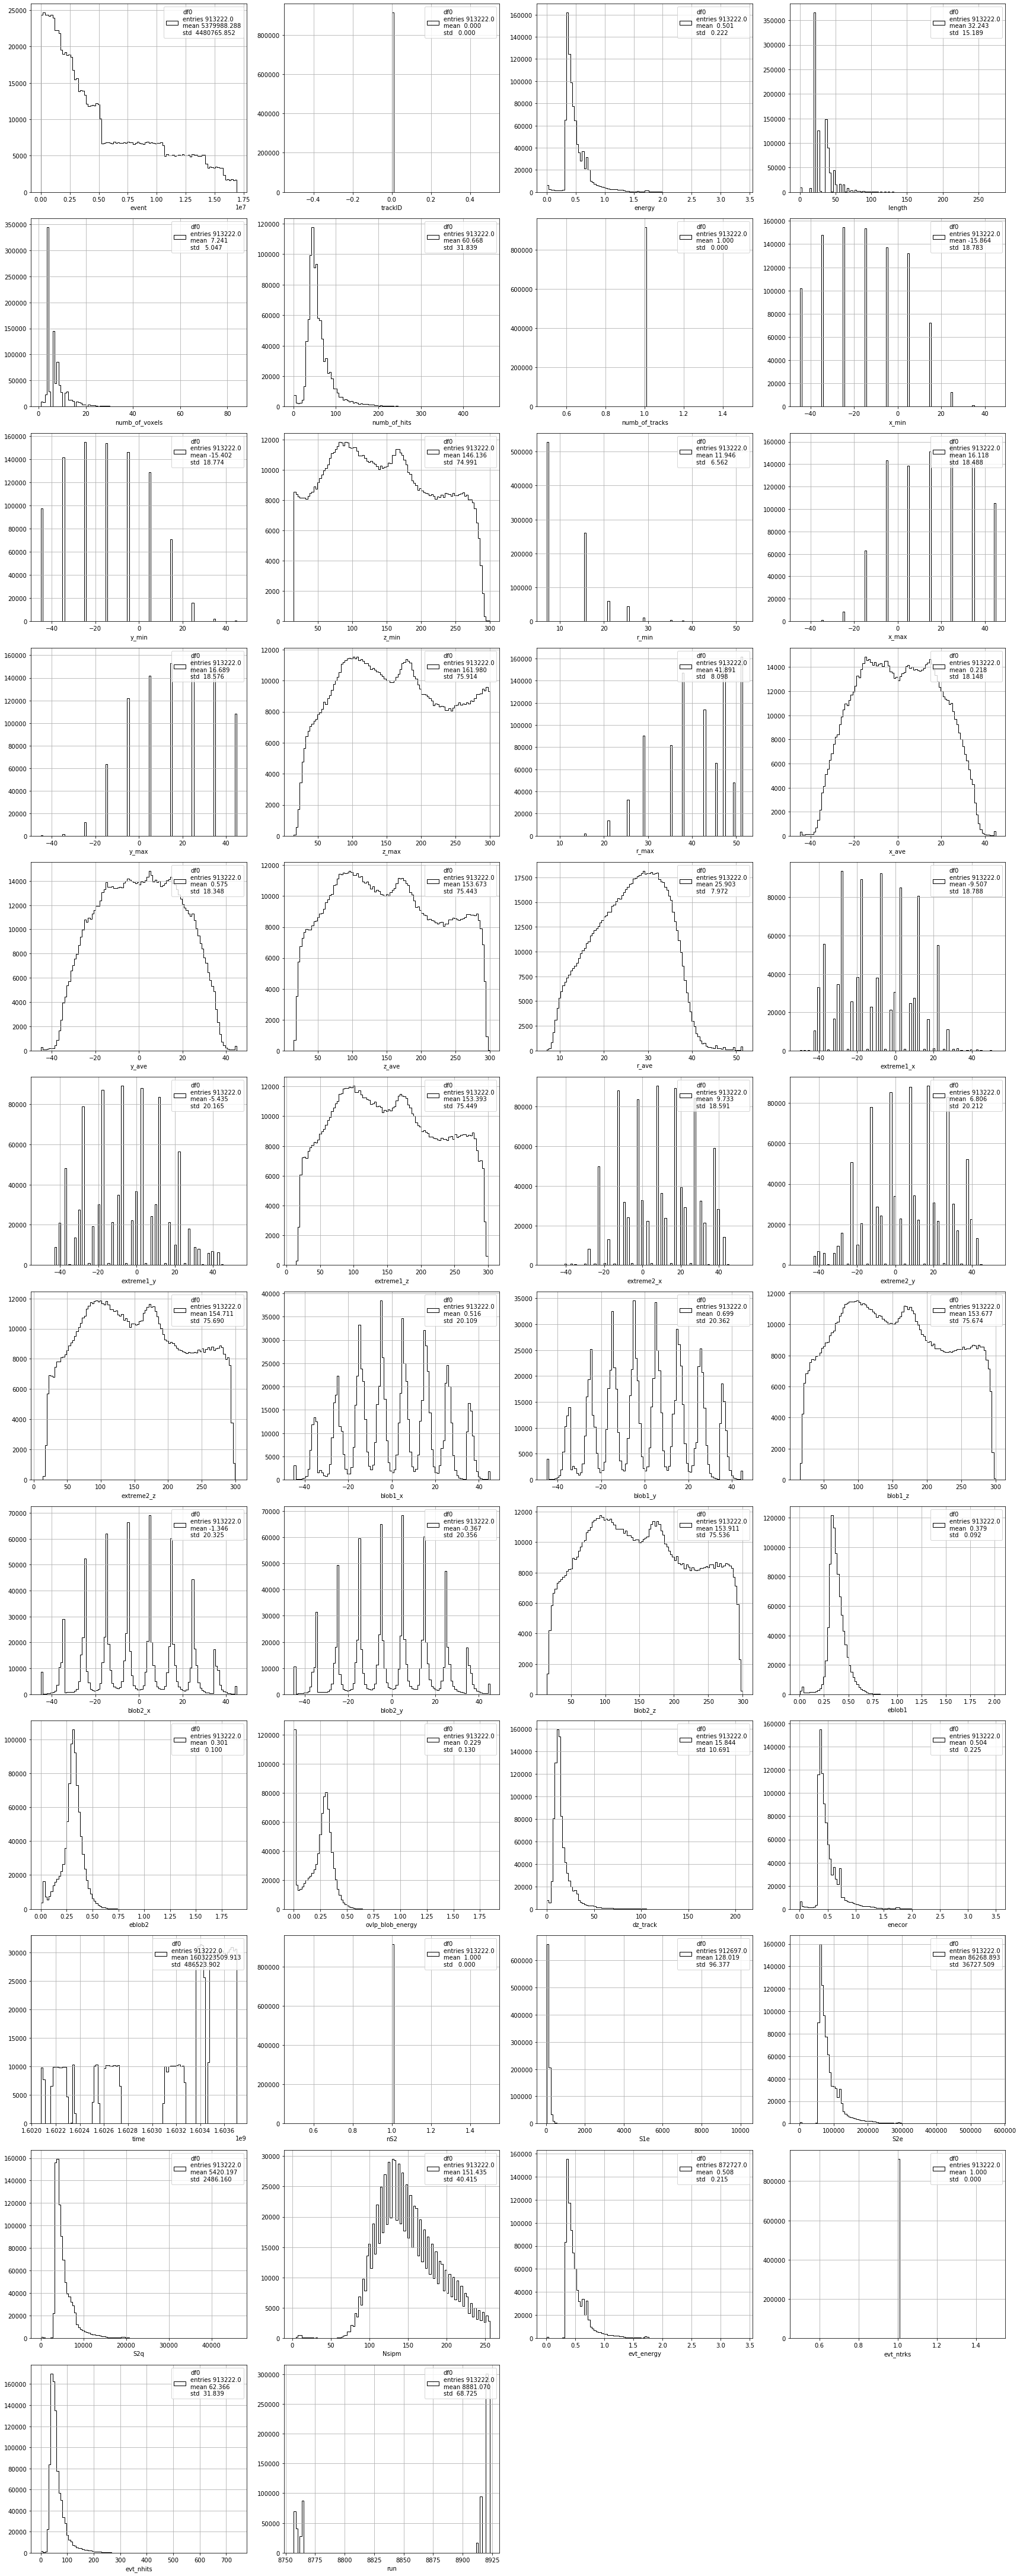

In [40]:
columns = list(dft.columns)
print(columns)
i = columns.index('evt_out_of_map') # problems with plotting, remove from the list to plot
columns.pop(i)
pltext.df_inspect(dft, columns, ncolumns = 4)

### selections and ranges

In [41]:
ranges = {'nS2'            : (1., 1.),
          'evt_out_of_map' : (False, False),
          'numb_of_tracks' : (1., 1.),
          'z_min'          : (15., 300.),
          'z_max'          : (15., 300.),
          'r_max'          : (0.,  55.),
          'energy'         : (0., 3.),
          'energy.cs'      : (0.68, 0.76),
          'energy.ds'      : (1.60, 1.85),
          'energy.ph'      : (2.00, 3.00),
          'dz_track.cs'    : (0., 60.),
          'dz_track.ds'    : (0., 150.)
         }
for key in ranges.keys():
    print(key, ranges[key])

nS2 (1.0, 1.0)
evt_out_of_map (False, False)
numb_of_tracks (1.0, 1.0)
z_min (15.0, 300.0)
z_max (15.0, 300.0)
r_max (0.0, 55.0)
energy (0.0, 3.0)
energy.cs (0.68, 0.76)
energy.ds (1.6, 1.85)
energy.ph (2.0, 3.0)
dz_track.cs (0.0, 60.0)
dz_track.ds (0.0, 150.0)


In [42]:
selections = nsel.Selections(dft, ranges)

In [43]:
selnames    = ('nS2', 'numb_of_tracks', 'z_min', 'z_max', 'r_max')
selections.logical_and(selnames, 'fidutial');

In [44]:
#pltext.df_inspect(dft[selections['fidutial']], columns[:-1], ncolumns = 3)

### Energy 

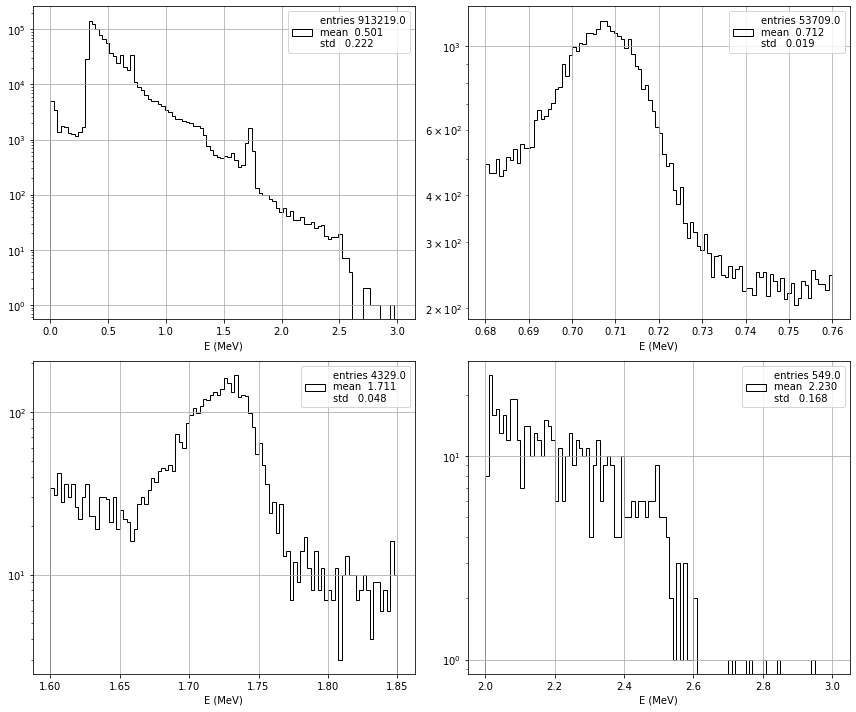

In [45]:
def plt_energies(enes, ranges, bins = 100):

    nplots = len(ranges)

    subplot = pltext.canvas(nplots, 2)
    
    for i in range(nplots):
        subplot( i + 1)
        pltext.hist(enes, bins, range = ranges[i], ylog = True, xylabels = 'E (MeV)'); 
    plt.tight_layout()

sel     = selections['fidutial']
eranges = [ranges[name] for name in ('energy', 'energy.cs', 'energy.ds', 'energy.ph')]
plt_energies(dft.energy[sel], eranges)
#plt_energies(dft.energy)

(0.7071135886865798, 0.008833179723084433, 0.00012837077603771328, 2.9355923406598756, 0.04266235701239488)
resolution R = 2.9356 +- 0.04266
(1.722476398295118, 0.018967153958335897, 0.00044030999504534126, 2.587716838744895, 0.06007214318760543)
resolution R = 2.5877 +- 0.06007


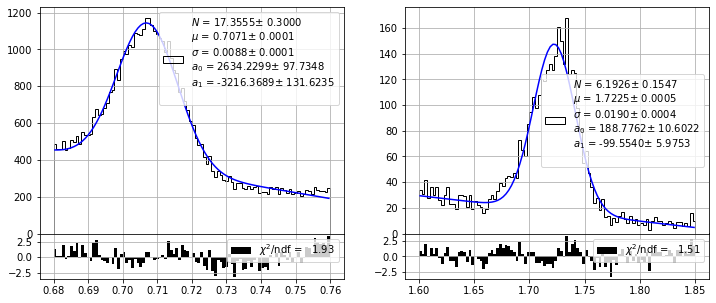

In [46]:
eranges = [ranges[name] for name in ('energy.cs', 'energy.ds')]
subplot = pltext.canvas(len(eranges))
for i, erange in enumerate(eranges):
    subplot(i + 1)
    pars = eres.energy_fit(dft.energy.values, 100, range = erange, plot = True)
    print(pars)
    print('resolution R = {0:6.4f} +- {1:6.5f}'.format(*pars[-2:]))

## Delta Z- Effect


In [47]:
def plt_dzeffect(dft, ename, erange, dzrange, bins = 10, p0 = None, alpha = 0.005):
    
    ene, dz = [dft[name].values for name in (ename, 'dz_track')]
    sel   = ut.in_range(ene, erange) & ut.in_range(dz, dzrange) 
    ene, dz = ene[sel], dz[sel] 

    subplot = pltext.canvas(2)
    subplot(1)
    plt.scatter(dz, ene,alpha = alpha, marker = '.');
    pltext.hprofile(dz, ene, bins = bins, xrange = (0., 120), percentile = True);
    subplot(2)
    plt.hist2d(dz, ene ,(bins, bins)); 
    
    p0s   = bins * [p0]
    len(ene), len(dz), np.sum(np.isnan(ene)), np.sum(np.isnan(dz))
    xmed, mus, sigs = eres.dz_effect_profile(dz, ene, bins, p0s = p0s, plot = True);
    
    pltext.canvas(1);
    plt.scatter(dz, ene, alpha = alpha, marker = '.');
    par, upars = eres.dz_effect(xmed, mus, sigs, plot = True);
    plt.xlabel(r'$\Delta$z (mm)'); plt.ylabel('E (MeV)');
    
    print('energy {:6.4f} slope {:8.6g}'.format(*par))
    
    return par

energy 0.7227 slope -0.000675674


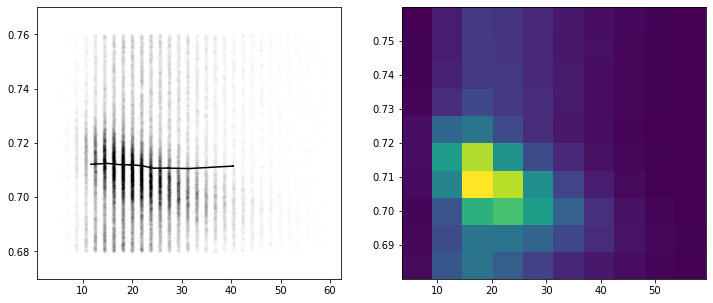

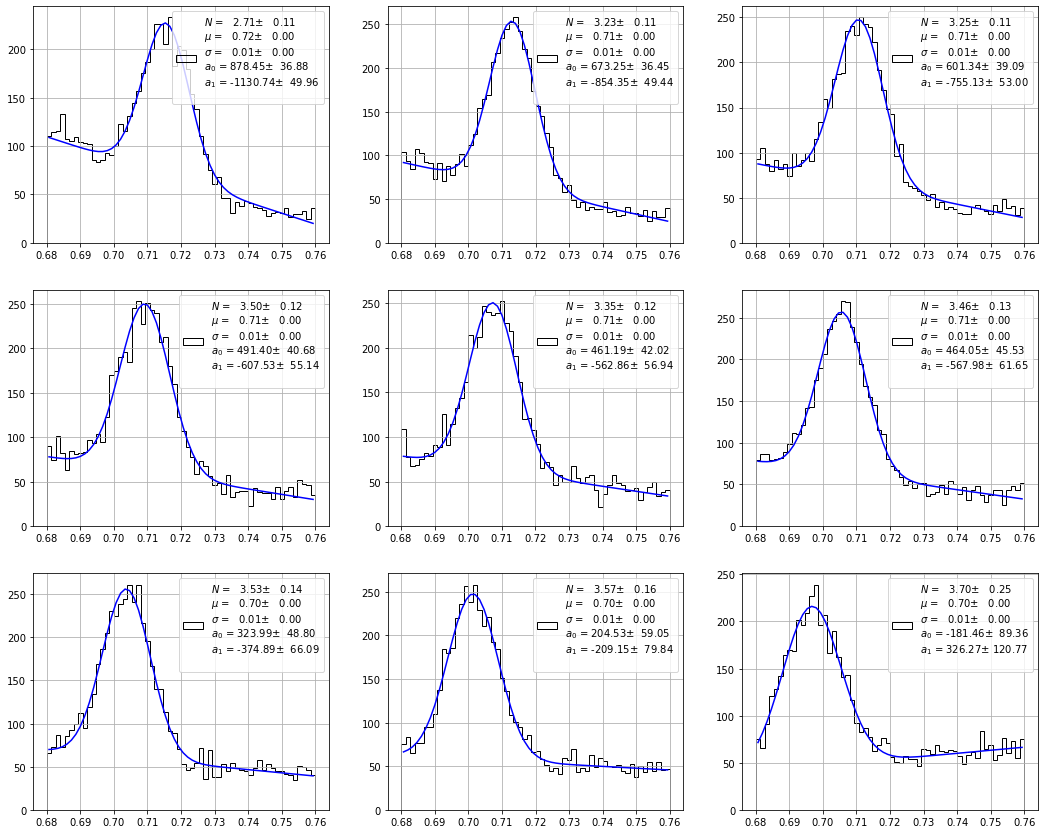

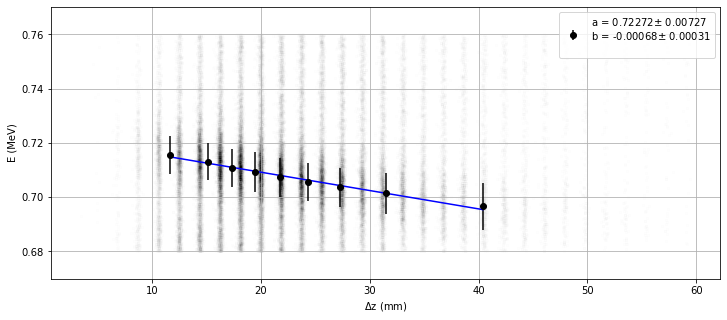

In [48]:
cs_par = plt_dzeffect(dft, 'energy', ranges['energy.cs'], ranges['dz_track.cs'], p0 = (10, 0.72, 0.02, 100., -100));

energy 1.7607 slope -0.000726235


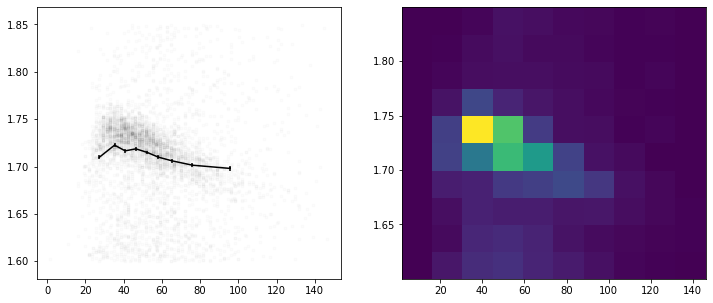

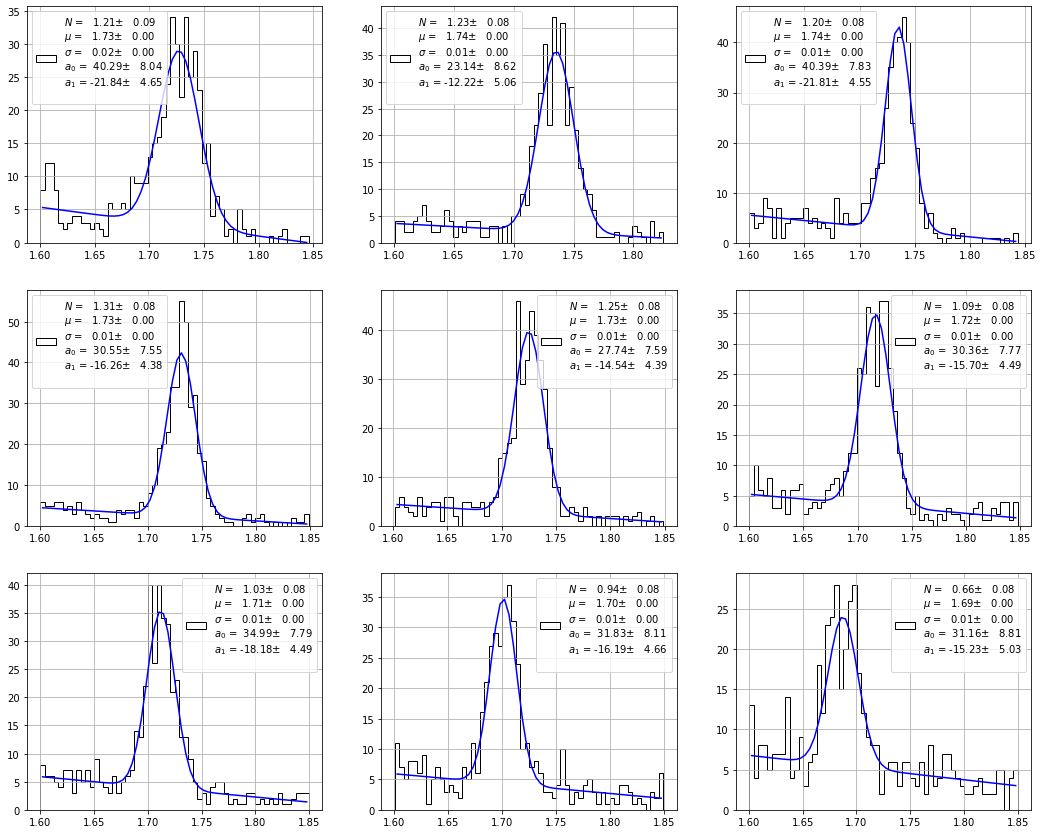

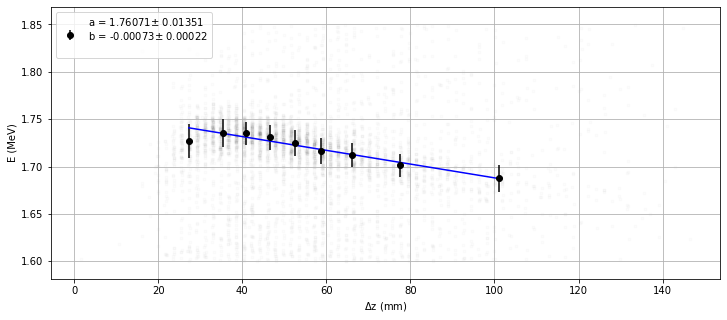

In [50]:
ds_par = plt_dzeffect(dft, 'energy', ranges['energy.ds'], ranges['dz_track.ds'], 
                      p0 = (10, 1.70, 0.02, 100., -100), alpha = 0.01);

## Energy correction

In [51]:
cor = 'ds'

energy_ds = 2.615 - 2 * 0.511
energy_cs = 0.663
#print(energy_ds)

ene0, slope = cs_par    if cor == 'cs' else ds_par
eneref      = energy_cs if cor == 'cs' else energy_ds
scale = eneref/ene0
alpha = abs(slope)/ene0

print(scale, alpha, ene0, eneref)

ene, dz = [dft[name].values for name in ('energy', 'dz_track')]
enecor  = eres.dz_energy_correction(ene, dz, alpha, scale)
dft.enecor = np.copy(enecor)

0.9047493244531973 0.00041246759346158984 1.7607086923914095 1.5930000000000002


## Energy resolution

In [53]:
ranges['enecor.cs'] = (0.62, 0.68)
ranges['enecor.ds'] = (1.50, 1.70)
ranges['enecor.ph'] = (2.00, 3.00)
for name in ('enecor.cs', 'enecor.ds', 'enecor.ph'):
    selections.set_range(name, ranges[name])

(0.6460394457075386, 0.007044703127288003, 8.507162666395441e-05, 2.5625451292677357, 0.03094521921046841)
resolution R = 2.5625 +- 0.03095
(1.5926710130308783, 0.012912353461549344, 0.0002797160503423349, 1.9052290389146838, 0.04127234770560509)
resolution R = 1.9052 +- 0.04127


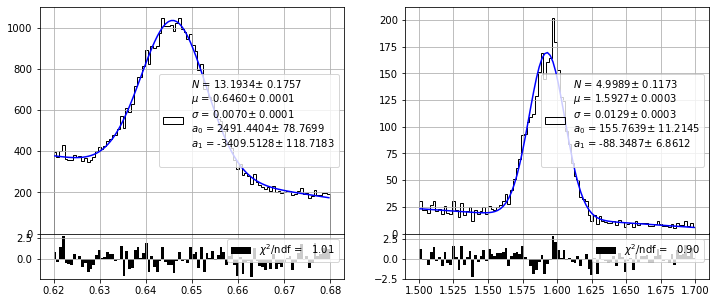

In [54]:
eranges = [ranges[name] for name in ('enecor.cs', 'enecor.ds')]
subplot = pltext.canvas(len(eranges))
for i, erange in enumerate(eranges):
    subplot(i + 1)
    pars = eres.energy_fit(dft.enecor.values, 100, range = erange, plot = True)
    print(pars)
    print('resolution R = {0:6.4f} +- {1:6.5f}'.format(*pars[-2:]))

## Check DZ

In [ ]:
cs_par = plt_dzeffect(dft, 'enecor', ranges['enecor.cs'], ranges['dz_track.cs'], p0 = (10, 0.66, 0.05, 10., -10));

In [ ]:
cs_par = plt_dzeffect(dft, 'enecor', ranges['enecor.ds'], ranges['dz_track.ds'], 
                      p0 = (10, 1.60, 0.02, 100., -100), alpha = 0.1);